# Clean-Label Feature Collision Attacks on a Keras Classifier

In this notebook, we will learn how to use ART to run a clean-label feature collision poisoning attack on a neural network trained with Keras. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/1804.00792) by Shafahi, Huang, et. al. 2018.

In [1]:
import os, sys
from os.path import abspath

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

num_samples_train = 1000
num_samples_test = 1000
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Load Model to be Attacked

In this example, we using a RESNET50 model pretrained on the CIFAR dataset.

In [3]:
path = get_file('cifar_alexnet.h5',extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_alexnet.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

Instructions for updating:
Colocations handled automatically by placer.


## Choose Target Image from Test Set

true_class: bird
predicted_class: bird


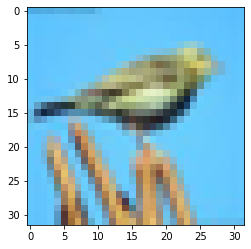

In [4]:
target_class = "bird" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][3], axis=0)

fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

feature_layer = classifier.layer_names[-2]

## Poison Training Images to Misclassify Test

The attacker wants to make it such that whenever a prediction is made on this particular cat the output will be a horse.

In [5]:
base_class = "frog" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]

x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


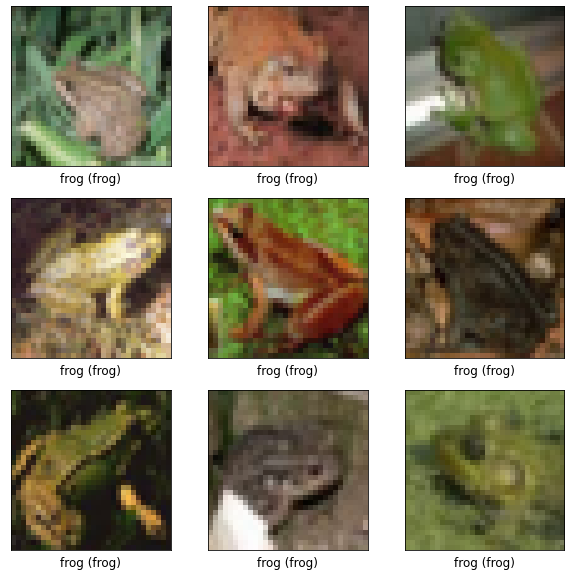

In [6]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(base_instances[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

The captions on the images can be read: `predicted label (true label)`

## Creating Poison Frogs

In [7]:
attack = FeatureCollisionAttack(classifier,
                                target_instance,
                                feature_layer,
                                max_iter=10,
                                similarity_coeff=256,
                                watermark=0.3,
                                verbose=False)

poison, poison_labels = attack.poison(base_instances)

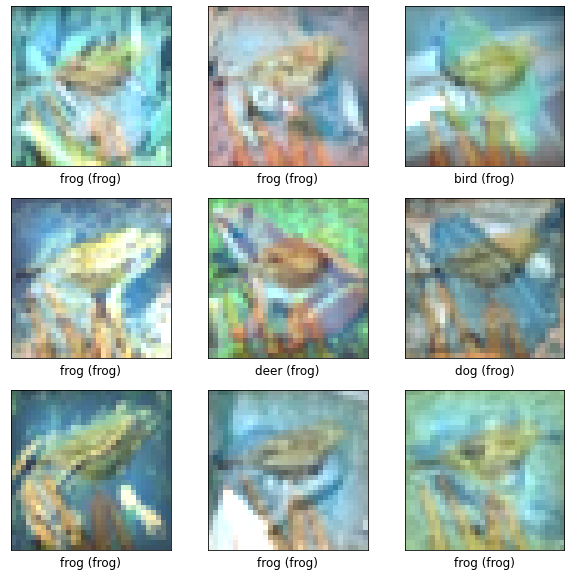

In [8]:
poison_pred = np.argmax(classifier.predict(poison), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(poison_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(poison[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

Notice how the network classifies most of theses poison examples as frogs, and it's not incorrect to do so. The examples look mostly froggy. A slight watermark of the target instance is also added to push the poisons closer to the target class in feature space.

## Training with Poison Images

In [9]:
adv_train = np.vstack([x_train, poison])
adv_labels = np.vstack([y_train, poison_labels])
classifier.fit(adv_train, adv_labels, nb_epochs=10, batch_size=4)

Train on 1010 samples
Epoch 1/10
1010/1010 [==============================] - 17s 17ms/sample - loss: 1.1883 - accuracy: 0.7931
Epoch 2/10
1010/1010 [==============================] - 15s 15ms/sample - loss: 0.8499 - accuracy: 0.8337
Epoch 3/10
1010/1010 [==============================] - 14s 14ms/sample - loss: 0.7501 - accuracy: 0.8475
Epoch 4/10
1010/1010 [==============================] - 14s 14ms/sample - loss: 0.7108 - accuracy: 0.8713
Epoch 5/10
1010/1010 [==============================] - 15s 15ms/sample - loss: 0.5849 - accuracy: 0.8822
Epoch 6/10
1010/1010 [==============================] - 14s 14ms/sample - loss: 0.5762 - accuracy: 0.8842
Epoch 7/10
1010/1010 [==============================] - 15s 14ms/sample - loss: 0.4543 - accuracy: 0.9059
Epoch 8/10
1010/1010 [==============================] - 14s 14ms/sample - loss: 0.4344 - accuracy: 0.9030
Epoch 9/10
1010/1010 [==============================] - 15s 15ms/sample - loss: 0.4214 - accuracy: 0.9149
Epoch 10/10
1010/1010 [=

## Fooled Network Misclassifies Bird

true_class: bird
predicted_class: frog


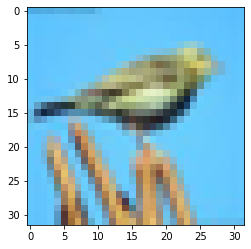

In [10]:
fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.